# Validazione e ottimizzazione iperparametri

In questo capitolo cercheremo di migliorare i risultati ottenuti con i passi precedenti, ottimizzando gli algoritmi e valutando bene i risultati.

## Caricamento del dataset e utilizzo delle pipeline
In questo capitolo utilizzeremo il dataset *Breast Cancer Wisconsin* le prime due colonne sono un identificativo del caso e la diagnosi corrispondente le caratterstiche dalla 3 alla 32 sono valori oggettivi ottenuti dalle immagini digitalizzare del nucleo della cellula.

In [2]:
import pandas as pd
df = pd.read_csv('./data/data.csv')

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
X = df.loc[:,'radius_mean':'fractal_dimension_worst']
y = df.loc[:,'diagnosis']

In [4]:
label_map = {'M': 1, 'B': 0}
y = y.map(label_map)

Ora che abbiamo creato il dataset nel formato desiderato andiamo a dividere i dati in due parti, l'80% verranno utilizzati per l'addestramento (train) mentre il 20% per testare la correttezza del nostro sistema (test).

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

### Combinare estimatori e trasformatori in una pipeline

Creiamo ora un sistema che esegua in un solo passo la trasformazione PCA vista nella lezione precedente e la regressione logistica.
Per svolgere questo lavoro usiamo l'oggetto `Pipeline`

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(solver='lbfgs'))
pipeline.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

In [7]:
score = pipeline.score(X_test,y_test)
print("Test accuracy: {0:.3f}".format(score))

Test accuracy: 0.947


La funzione `make_pipeline` accetta in ingresso un numero arbitrario di transformer (che supportano sia il metodo `fit` che il metodo `transform`) seguito da un oggetto estimatore che implementa i metodi `fit` e `predict`.

Possiamo pensare che l'oggetto `Pipeline` sia una box in cui quando chiamiamo il metodo `fit` i dati passano attraverso tutti i trasformatori (viene chiamato il metodo `fit`) fino ad arrivare al trasformatore finale.

Quando invece viene chiamato il metodo `predict` i dati passano attravesrso i trasformatori utilizzando il metodo `tranform` fino ad arrivare alla fine dove incontrano l'estimatore in cui viene richiamato il metodo `predict`.

## Utilizzo della convalida incrociata k-fold per valutare le prestazioni del modello

Per impostare bene il nostro modello dobbiamo trovare un buon compromesso tra underfitting e overfitting nei prossimi passi affronteremo le varie strategie per per stimare l'errore di generalizzazione.

### Il modello holdout
L'approccio classico per la stima delle prestazioni è il modello holdout, con esso si divide il dataset in due parti train e test. Il primo viene ovviamente utilizzato per il train ed il secondo per il test finale tuttavia siamo interessati anche ad ottimizziare i parametri che lo stesso mette a disposizione *(iperparametri)*. Tuttavia se utilizzassimo i dati di test per l'ottimizzazione essi finirebbero a far parte dei nostri dati di train ed il modello andrebbe certamente in contro ad un problema di overfitting.
Per ovviare a questo problema si divide il dataset di train in due pessi la parte di train e la parte di convalida che verrà utilizzata per calcorare la migliore combinazione di iperparametri.
Una volta eseguito questi passaggi potremmo finalmente utilizzare il dataset di test per controllare il comportamento del modello.
Lo svantaggio di questo sistema sta nel fatto che è fortemente legato al modo in cui i dati vengono divisi.

Nel prossimo paragrafo andremo ad analizzare la convalida incrociata che essenzialmente ripete il modello holdout sul dataset n volte, con una stima più precisa.

### Convalida incrociata K-fold
Nella convalida incrociata K-fold, suddividiamo in modo casuale il dataset di addestramento in k parti senza reinserimento, k-1 parti verranno utilizzate per l'addestramento del modello e l'ultima verrà utilizzata per verificare le caratteristiche del modello. Questa procedura viene ripetuta k volte con k stime di prestazioni.

Per calcolare i parametri migliori da utilizzare sul modello di utilizza il metodo k-fold, una volta eseguito questo passo si riesegue l'addestramento sull'intero dataset di train e si ottiene la stima finale utilizzando il dataset di test.
Il valore standard di k è pari a 10, di solito questo valore è sufficiente per la maggior parte dei casi.
Se stiamo lavorando con dataset piccoli potremo scegliere un valore di k più grande per avere un dataset di addestramento il piu grande possibile. Tuttavia avremo anche dei risultati intermedi con varianzia più elevata.

Per dataset molto grandi invece conviene usare valori più piccoli ad esempio k = 5, per ridurre anche il costo computazionale.

Un leggero miglioramento del sistema k-fold è la convalida incrociata k-fold stratificata, con questo tipo di convalida le proporzioni tra le classi vengono preservate in ciascuna parte, per garantire che ciascuna parte abbia una rappresentazione delle classi uguale.
Qui sotto mostriamo un esempio di come funziona tale iteratore `StratifiedKFold`

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

scores = []
for train_index, test_index in skf.split(X_train,y_train):
    pipeline.fit(X_train.iloc[train_index],y_train.iloc[train_index])
    score = pipeline.score(X_train.iloc[test_index],y_train.iloc[test_index])
    
    print("Class dist {0} accuracy {1:.2f}".format(np.bincount(y_train.iloc[train_index]),score))
    
    scores.append(score)
    
print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))

Class dist [252 157] accuracy 0.98
Class dist [252 157] accuracy 0.89
Class dist [252 157] accuracy 0.98
Class dist [252 157] accuracy 0.96
Class dist [252 157] accuracy 0.93
Class dist [252 158] accuracy 0.98
Class dist [252 158] accuracy 0.89
Class dist [252 158] accuracy 0.93
Class dist [252 158] accuracy 0.96
Class dist [252 158] accuracy 0.93
CV accuracy 0.94 +/- 0.03


Sebbene il precedente codice fosse utile per comprendere il funzionamento del metodo sklean implementa già tutti i passaggi attraverso la funzione `cross_val_score`

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline,X_train,y_train,cv=10,n_jobs=-1)

print("CV scores {0}".format(scores))
print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))

CV scores [0.97826087 0.89130435 0.97826087 0.95652174 0.93478261 0.97777778
 0.88888889 0.93333333 0.95555556 0.93333333]
CV accuracy 0.94 +/- 0.03


una cosa interessante di questo ultimo metodo è che possiamo distribuire la valutazione delle varie parti su più cpu, se impostiamo il parametro `n_jobs=-1` potremmo utilizzare tutte le cpu disponibili.

## Debugging degli algoritmi con le curve di apprendimento e convalida

Ora esamineremo due semplici quanto potenti stumenti per analizzare le perfomance dell'algoritmo 

### Diagnosi dei problemi di bias e varianza con le curve di apprendimento
Se il modello è troppo complesso per un determinato dataset di addestramento il modello tende a non convergere bene sui dati di test e dunque non generalizzare bene su dati mai visti.
Tuttavia basterebbe ottenere più dati per mitigare il problema, questo però può risultare difficile se non impossibile.
Tracciando il comportamento del modello in funzione dell'aumentare dei dataset possiamo individuare se il modello soffre di elevata varianza o bias.


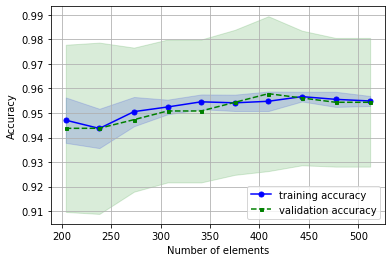

In [10]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=10, n_jobs=-1,train_sizes=np.linspace(0.4,1,10))

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)

test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',marker='s',linestyle="--",markersize=3,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15,color='green')

plt.grid()

plt.xlabel("Number of elements")
plt.ylabel("Accuracy")
plt.legend(loc = 'lower right')

### Soluzione di problemi di overfitting e underfitting con le curve di convalida

Le curve di convalida sono un ottimo strumento per migliorare le prestazioni di un modello risolvendo i problemi di overfitting. Qui invece di tracciare le curve in funzione della dimensione del campione qui si interviene sui parametri del modello.

Vediamo qui sotto un esempio di curva al variare di C

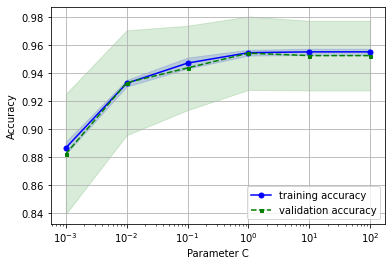

In [11]:
from sklearn.model_selection import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]

train_scores,test_scores =  validation_curve(pipeline, X, y,param_name='logisticregression__C',param_range=param_range,cv=10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)

test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)


plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean + train_std,train_mean - train_std,alpha=0.15,color='blue')

plt.plot(param_range,test_mean,color='green',marker='s',linestyle="--",markersize=3,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15,color='green')

plt.grid()
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc = 'lower right')


notiamo che con c > 1 l'accuratezza non aumenta e si ha inoltre un leggero overfit

## Ottimizzazione dei modelli di machine learning tramite ricerca a griglia
Come abbiamo sempre visto fino ad ora negli algoritmi di machine learning abbiamo due tipi di parametri che vengono appresi, quelli in fase di addestramento e gli iperparametri per esempio la regolarizzazione che devono essere ottimizzati separamatente.

Nel codice precedente abbiamo visto come le curve di convalida ci possano aiutare nel cercare il parametro migliore, ma ora vedremo una tecnica che ci aiuterà nel cercare in automatico i parametri da ottimizzare nel miglior modo possibile.

### Ottimizzazione dei parametri tramite ricerca a griglia
Questo tipo di ricerca è piuttosto semplice si tratta di una ricerca tramite forza bruta, il computer valuta tutte le combinazioni per cercare la combinazione vediamo un esempio pratico

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),SVC())

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [
    {
    'svc__C':param_range,
    'svc__kernel':['linear']
    },
     {
    'svc__C':param_range,
    'svc__gamma':param_range,
    'svc__kernel':['rbf']
    }
]


gs = GridSearchCV(estimator = pipe_svc,param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
gs = gs.fit(X_train,y_train)

print("Best score {0:.2f}".format(gs.best_score_))

print(gs.best_params_)

Best score 0.98
{'svc__C': 1.0, 'svc__kernel': 'linear'}


Una volta ottimizzato il modello andiamo a controllare come si comporta nel dataset di test

In [13]:
clf = gs.best_estimator_
clf.fit(X_train,y_train)

score = clf.score(X_test,y_test)
print("Test accuracy {0:.2f}".format(score))

Test accuracy 0.98


sebbene la ricerca a griglia sia uno strumento molto potente, su dataset molto grandi e con molti parametri potremmo avere dei problemi prestazionali.

Un buon approccio potrebbe essere quello di utilizzare la ricerca casuale con la classe `RandomizedSearchCV`

In [14]:
from sklearn.model_selection import RandomizedSearchCV

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [
    {
    'svc__C':param_range,
    'svc__kernel':['linear']
    },
     {
    'svc__C':param_range,
    'svc__gamma':param_range,
    'svc__kernel':['rbf']
    }
]


rs = RandomizedSearchCV(estimator = pipe_svc,param_distributions = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
rs = rs.fit(X_train,y_train)

print("Best score {0:.2f}".format(rs.best_score_))

print(rs.best_params_)



Best score 0.97
{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10.0}


In [15]:
clf = rs.best_estimator_
clf.fit(X_train,y_train)

score = clf.score(X_test,y_test)
print("Test accuracy {0:.2f}".format(score))

Test accuracy 0.96


## Selezione dell'algoritmo con convalida incrociata nidificata

L'utilizzo della convalida incrociata *k-fold* in combinazione con la ricerca a griglia/randomica è un ottimo strumento per l'ottimizzazione degli iperparametri. Ma se volgiamo selezionare fra vari algoritmi una buona soluzione potrebbe essere quella di utilizzare la convalida incrociata nidificata. 

Si parte da un ciclo esterno dove si usa la cross validation per validare i dati e fornire ad un ciclo più interno gli stessi per ottimizzare i parametri del modello.

La figura qui sotto introduce il concetto di una convalida incrociata 5x2

![convalida incrociata nidificata](./images/crossValidation.png)

Per eseguire questo tipo di convalida con sklearn basta utilizzare le seguenti linee di codice


In [16]:
rs = RandomizedSearchCV(estimator = pipe_svc,param_distributions = param_grid, scoring = 'accuracy', cv = 2, n_jobs = -1)
scores = cross_val_score(rs,X_train,y_train,cv=5,n_jobs=-1)

print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))


CV accuracy 0.97 +/- 0.02


## Metrice di valutazione delle prestazioni

Fino ad ora abbiamo sempre utilizzato come metro per la prestazione di un algoritmo l'accuratezza, come vedremo nei prossimi capitoli esistono anche altre metriche prestazionali tra cui: precisione, recall e F1-score

### Lettura di una matrice di confusione

Prima di entrare nel dettaglio di una classe di metriche dobbiamo trattare la cosidetta matrice di confusione.
Questa è una matrice quadrata che contiene il conteggio dei veri positivi, dei veri negativi, dei falsi positivi e dei falsi negativi.

Sebbene questa metrica possa essere calcolata con facilità abbiamo una funzione di sklearn che ci viene in aiuto.


In [17]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
matrix

array([[76,  1],
       [ 2, 35]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

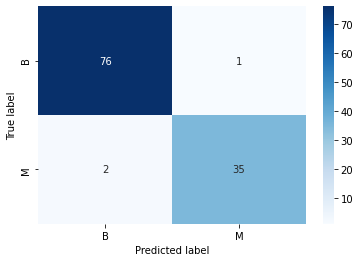

In [18]:
import seaborn as sns

categories = ['B', 'M']
sns.heatmap(matrix, annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Ottimizzazione della precision e della recall di un modello di classificazione

L'accuratezza del modello ovvero il rapporto tra le previsioni corrette ed il numero totale di previsioni, utilizzando le 4 celle della matrice di confusione potremmo scrivere utilizzando le seguenti sigle:

+ TP veri positivi
+ TN veri negativi
+ FP falsi positivi
+ FN falsi negativi

$$ACC = \frac{TN + TP}{TN + TP + FN + FP}$$

Però esitono anche altre metriche che potrebbero venirci in aiuto nel caso il dataset sia sbilanciato, ad esempio prendendo questo schemino di matrice 

![matrice confusione](./images/confusionMatrix.png)

Definiamo il tasso dei veri positivi come il rapporto del valore TP (veri positivi) e P (i valori positivi nel nostro dataset), ma come vediamo nella immagine $P = TP + FN $ perciò il valore TPR sarà

$$TPR = \frac{TP}{P}  =\frac{TP}{FN + TP}$$

Con lo stesso sitema definiamo anche la metrica FPR che si può definire come il rapporto tra i falsi positivi e la classe del dataset negativa

$$FPR = \frac{FP}{N} = \frac{TP}{FP + TN}$$

### Precision e Recall

Parliamo ora di precisione e recall, per precisione intendiamo il rapporto i veri positivi (TP) e le previsioni positive totali (TP + FP):

$$PRE = \frac{TP}{TP + FP}$$

La recall invece è il rapporto tra i veri positivi (TP) e i valori positivi nel nostro dataset (P) se notate è la definizione di TPR

Per capire un pochino meglio il funzionamento della precision e della recall facciamo un esperimento mentale, potrei affermare di aver costruito un modello che riesce ad identificare il 99% dei terroristi che cercano di imbarcarsi su un volo.

Voi potreste essere stupiti ma aspettate di vedere il ragionamento ....

Su una media dei viaggiatori americani di 800 milioni di passeggeri annui (stima del 2017) il numero di terroristi confermati dal 2000 al 2017 è stato di 17 persone. Per avere una accuratezza del 99% basterebbe semplicemente segnare tutti i passeggeri come non terroristi ...

Convenite con me che questo ragionamento non è corretto, il problema sta nel fatto che siamo di fronte ad un dataset fortemente sbilanciato e la metrica dell'accuratezza non funziona in questo tipo di problema.

Utilizziamo ora la recall sul nostro dataset dei terroristi questa si concentrerà nello scovare tutti i casi rilevanti (i terroristi) nel nostro dataset usando le formule di prima avremo che 

$$RECALL = \frac{TP}{FN + TP} =  \frac{\textrm{terroristi correttamente identificati}}{\textrm{terroristi non idenficati} + \textrm{terroristi correttamente identificati}}$$

Ora se il nostro modello fosse in grado di identificare tutti i terroristi non avremmo falsi negativi e la recall avrebbe valore 1. Il nostro però sarebbe un modello perfetto ?

Non esattamente, vediamo il perchè. Se marchiamo tutti i viaggiatori come terroristi per assurdo non avremo nessun falso positivo, e la recall avrebbe come valore 1.

In questo caso il nostro modello si dice che non è molto *preciso*, ragioniamo con la formula adattata al nostro caso:

$$PRECISION = \frac{TP}{TP + FP} = \frac{\textrm{terroristi correttamente identificati}}{\textrm{terroristi correttamente identificati} + \textrm{viaggiatori identificati come terroristi}}$$

Dunque ricapitolando se la recall misura la capacità di scovare i terroristi nel nostro dataset, la precisione (lo dice la parola stessa) misura la capacità di scovare i dati in modo preciso nel nostro dataset.

Ma anche la recall da sola non funzionerebbe perfettamente in quanto ad esempio pensiamo ad un modello che idenfichi correttamente un solo terrorista dei 17, avremmo una precisione pari a 1 ma ancora questo modello non sarebbe quello che vogliamo.


Ma facciamo un passo indietro e proviamo a misuare la precision e recall del primo modello (nessun terrorista) sebbene l'accuratezza sia quasi del 99.9% le due misure avrebbero come 0 in quanto non avremmo nessun terrorista scovato.

Passiamo ora al modello che identifica un solo terrorista nel modo corretto, come detto prima la nostra precisione sarà pari ad 1 perchè non abbiamo nessun falso positivo, in questo caso però la recall avrebbe un valore molto basso in quanto avremmo molti falsi negativi.

Scegliamo ora il modello più crudele, che identifica tutti i viaggiatori come terroristi, abbiamo già detto che la nostra recall avrebbe come valore 1 con un valore della precisione molto basso.

Si intuisce dunque che per avere un buon modello bisognerebbe avere un valore di precisione di recall il più possibile alti e che all'aumentare di una misura molto spesso si va a diminuire la seconda.


### Combinare precision e recall

Sebbene ci siano situazioni in cui si voglia aumentare il più possibile una misura a descapito dell'altra. Ad esempio se volessimo creare un modello per lo screening di una malattia forse la recall sarebbe più importante della precisione, in quanto un secondo esame, più preciso e di solito più costoso potrebbe dare il risultato voluto.

Comunque negli altri casi un buon compromesso potrebbe essere la metrica F1.
L'F1 score è la media armonica della precisione e della recall, viene misurata nel seguente modo:

$$F_{1} = 2 * \frac{PRECISION * RECALL}{PRECISION + RECALL}$$


Si è scelta la media armonica in quanto punisce i valori estremi (Ad esempio precisione 1 e recall 0) e crea un buon bilanciamento tra recall e precision

andiamo ora a visualizzare queste metriche sul nostro modello precedentemente addestrato

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision\t{0:.3f}".format(precision_score(y_test,y_pred)))
print("Recall\t\t{0:.3f}".format(recall_score(y_test,y_pred)))
print("F1\t\t{0:.3f}".format(f1_score(y_test,y_pred)))

Precision	0.972
Recall		0.946
F1		0.959


per addestrare il modello con una metrica diversa dall'accuratezza bisgona dare il valore voluto al parametro `scoring` inoltre per sklearn la classe positiva per default ha valore 1 per cambiare il comportamento di default va costruiro uno scorer ad hoc attraverso la funzione `make_scorer`. vediamo un esempio pratico sempre sul dataset breast cancer.

In [20]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score,pos_label=1)

rs = RandomizedSearchCV(estimator = pipe_svc,param_distributions = param_grid, scoring = scorer, cv = 10, n_jobs = -1)
rs = rs.fit(X_train,y_train)

print("Best score {0:.2f}".format(rs.best_score_))

print(rs.best_params_)

clf = rs.best_estimator_
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

score = f1_score(y_test,y_pred)
print("Test f1 score {0:.2f}".format(score))


Best score 0.96
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 1000.0}
Test f1 score 0.94


## Tracciamento delle curve ROC

La curva roc è un grafico che mostra le performanca del nostro modello binario a tutte le se soglie di classificazione.
Questa curva traccia due parametri.

* il parametro TPR
* il parametro FPR definito anche come tasso dei falsi allarmi

Tale curva traccia questo rapporto tra i due parametri alle differenti soglie di classificazione.
Come detto prima abbassando il valore della soglia aumenteremo si il numero dei campioni classificati come positivi andando ad incrementare la RECALL ma aumenteremo anche il tasso dei falsi allarmi. 

Vediamo un esempio di curva su sui effettuare i nostri ragionamenti:

![curva roc](./images/roc.png)

Per tracciare questa curva la prima soluzione potrebbe essere quella di eseguire il classificatore per ogni valore della soglia ma questo sarebbe oneroso in termini computazionali.
Vediamo un esempio di tracciatura su un dataset giocattolo.



In [21]:
import pandas as pd

examples_data = {
    "y_hat": [0.1,0.15,0.2,0.22,0.3,0.4,0.5,0.55,0.57,0.6,0.66,0.7,0.88,0.9,0.98],
    "y": [0,0,0,0,0,0,1,0,0,1,0,1,1,1,1]
}
 
examples = pd.DataFrame(examples_data)

examples.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y_hat,0.1,0.15,0.2,0.22,0.3,0.4,0.5,0.55,0.57,0.6,0.66,0.7,0.88,0.9,0.98
y,0.0,0.00,0.0,0.00,0.0,0.0,1.0,0.00,0.00,1.0,0.00,1.0,1.00,1.0,1.00


la colonna Predict contiene il valore della probabilità delle previsioni nel nostro modello mentre la True contiene il valore desiderato. 

Cominciamo con l'impostare la soglia con qualche valore e calcoliamo il punto del grafico

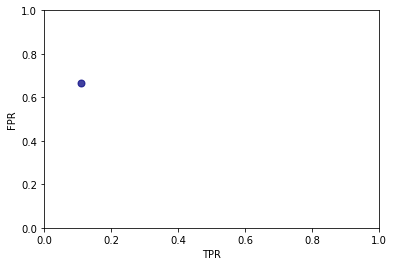

In [22]:
import matplotlib
import matplotlib.pyplot as plt


treshold = 0.6


def confusion_matrix(data,treshold):
    y_hat = data.y_hat > treshold
    y = data.y
    match = y_hat == y
    
    TP = match & y
    TN = match & ~y
    FP = ~match & ~y
    FN = ~match & y
    
    return TP.sum(),TN.sum(),FP.sum(),FN.sum()


TP,TN,FP,FN = confusion_matrix(examples,treshold)
TPR = TP / (FN + TP)
FPR = FP / (FP + TN)


plt.xlabel("TPR")
plt.ylabel("FPR")
plt.xlim([0,1])
plt.ylim([0,1])


plt.plot(FPR,TPR,color="navy",alpha=0.75,lw = 3,ls="-.",marker="o",markersize=7)


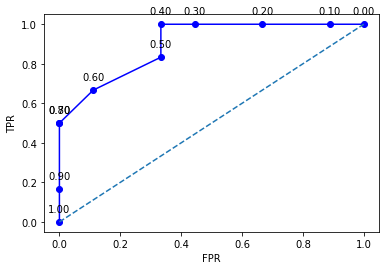

In [23]:
tresholds = [x * 0.1 for x in range(0, 11)]

TPR = []
FPR = []
for treshold in tresholds:
    TP,TN,FP,FN = confusion_matrix(examples,treshold)
    TPR.append(TP / (FN + TP))
    FPR.append(FP / (FP + TN))
    
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.plot(FPR,TPR,'bo-')
plt.plot([0,1],[0,1],linestyle="--")


for x,y,treshold in zip(FPR,TPR,tresholds):
    label = "{:.2f}".format(treshold)
    plt.annotate(label, 
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
    


Ora che abbiamo visto come viene tracciata la curva facciamo un ulteriore passo in avanti e proviamo a ragionare sul seguente schema che contiene due corve roc-

![auc](./images/auc.jpg)

secondo voi quale sarà il classificatore che si comporta meglio, il blu o il rosso ? 
Senza tanti sforzi possiamo dire che il classificatore associato alla linea rossa si comporta meglio di quello associato alla linea blu.

Ma come possiamo ottenere un numero che rappresenti questo comportamento? Ecco che ci viene in aiuto la metrica AUC che sta per Area Under Curve, che non rappresenta niente altro che l'intergrale calcolato sulla curva.

Applichiamo dunque quanto abbiamo appreso sul classificatore addestrato in questo capitolo e analizziamo il risultato.

In [24]:
from sklearn.metrics import roc_curve, auc


y_test_pred = clf.decision_function(X_test)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

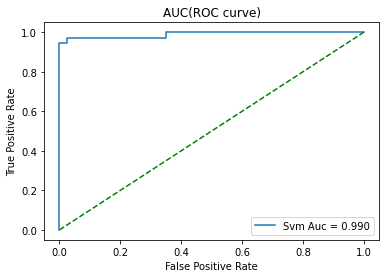

In [25]:
plt.grid()
plt.plot(test_fpr, test_tpr, label="Svm Auc = {0:.3f}".format(auc(test_fpr, test_tpr)))

plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

## Curva Precision Recall

La ROC non è l'unica curva che possiamo tracciare ad esempio anche la curva che mostra il rapporto tra il valore della precision e della recall sempre al variare della soglia.

Facciamo un esempio sempre con il dataset giocattolo usato prima

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


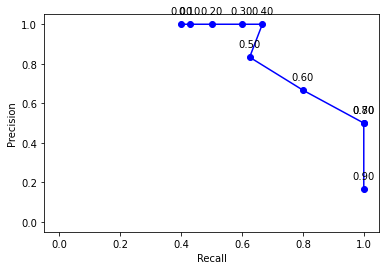

In [26]:
tresholds = [x * 0.1 for x in range(0, 11)]

PRECISION = []
RECALL = []
for treshold in tresholds:
    TP,TN,FP,FN = confusion_matrix(examples,treshold)
    PRECISION.append(TP/(TP+FN))
    RECALL.append(TP/(TP+FP))


    
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.plot(RECALL,PRECISION,'bo-')
#plt.plot([0, 1],linestyle="--")


for x,y,treshold in zip(RECALL,PRECISION,tresholds):
    label = "{:.2f}".format(treshold)
    plt.annotate(label, 
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')


Calcoliamo questa curva anche per il modello della pipeline vista prima

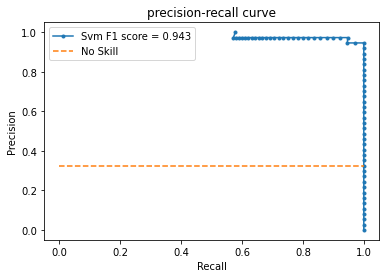

In [27]:
from sklearn.metrics import precision_recall_curve

y_test_pred = clf.decision_function(X_test)
y_hat = clf.predict(X_test)
test_precision, test_recall, te_thresholds = precision_recall_curve(y_test, y_test_pred)

plt.grid()
plt.plot(test_precision, test_recall,marker='.' ,label="Svm F1 score = {0:.3f}".format(f1_score(y_test, y_hat)))

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("precision-recall curve")
plt.grid(color='black', linestyle='-',linewidth=0.5)
plt.show()

Quando sarebbe meglio usare una o l'altra curva ? 
Questo dipende dal contesto, se il dataset è bilanciato andrebbe utilizzata la curva curva roc, mentre se il dataset è fortemente sbilanciato la precision-recall da un risultato migliore in quanto la precision riesce a lavorare meglio su un dataset sbilanciato. 


Per una trattazione migliore si consiglia la lettura di questo articolo 

[How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

## Lavorare con classi molto sbilanciate
Abbiamo parlato di classi sbilanciate, ma fino ad ora non abbiamo discusso su come trattare il problema.
I dataset fortemente sbilanciati non sono un evento raro nella vita reale, prendiamo ad esempio i seguenti problemi, lo spam filtering i controlli antifrode e la diagnosi di malattie rare.

Tenendo a memoria i ragionamenti fatti sul modello analisi dei viaggiatori/terroristi costruiamo un dataset fortemente sbilanciato.

In [28]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)

unique, counts = np.unique(y, return_counts=True)
total = y.shape[0]

for number,values in zip(unique, counts):
    print("La classe con valore {0} ha {1} elementi percentuale {2:.2f}".format(number,values,values/total))

La classse con valore 0 ha 985 elementi percentuale 0.98
La classse con valore 1 ha 15 elementi percentuale 0.01


Lo sbilanciamento della classe influenza il comportamento del modello nella fase di training, nello specifico tali sistemi come spiegato nella prima parte del corso ottimizzeranno la funzione di costo su tutti i campioni del dataset.

E' ovvio che se il dataset andrà condizionare il modello in base alla classe più numerosa.
Un modo per andare a mitigare il problema è assegnare una penalità maggiore sugli errori della classe meno numerosa, Sklearn implementa questo meccanismo attraverso il parametro `class_weight` assegnando il valore `class_weight="balanced"` 

Un altro modo per trattare il problema è tramite l'upsumpling della classe minoritaria o downsampling della classe con più elementi oppure ancora tramite la generazione di dati sintetici.

Per eseguire l'upsumpling/downsampling sklearn mette a disposizione il metodo resample qui sotto un esempio

In [36]:
from sklearn.utils import resample

print("Numero di elementi con classe 1 prima del resample {0}".format(y[y==1].shape[0]))

X_up,y_up = resample(X[y==1],y[y==1],replace=True,n_samples=X[y==0].shape[0])

print("Numero di elementi con classe 1 dopo del resample {0}".format(y_up[y_up==1].shape[0]))

X_bal = np.vstack((X[y==0],X_up))
y_bal = np.hstack((y[y==0],y_up))

unique, counts = np.unique(y_bal, return_counts=True)
total = y_bal.shape[0]

for number,values in zip(unique, counts):
    print("La classe con valore {0} ha {1} elementi percentuale {2:.2f}".format(number,values,values/total))

Numero di elementi con classe 1 prima del resample 15
Numero di elementi con classe 1 dopo del resample 985
La classe con valore 0 ha 985 elementi percentuale 0.50
La classe con valore 1 ha 985 elementi percentuale 0.50


In [47]:
trainX, testX, trainy, testy = train_test_split(X_bal, y_bal, test_size=0.3)



pipe_regression = make_pipeline(StandardScaler(),LogisticRegression(solver='lbfgs'))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [
     {
    'logisticregression__C':param_range
    }
]


rs = RandomizedSearchCV(estimator = pipe_regression,param_distributions = param_grid, scoring = 'precision', cv = 5, n_jobs = -1)
rs = rs.fit(trainX,trainy)

print("Best score {0:.2f}".format(rs.best_score_))

print(rs.best_params_)


clf = rs.best_estimator_
clf.fit(trainX,trainy)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best score 0.82
{'logisticregression__C': 1.0}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Logistic: f1=0.832 auc=0.811


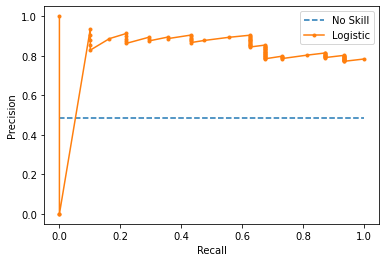

In [48]:
lr_probs = clf.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(yhat,testy)
matrix

array([[240,  36],
       [ 65, 250]], dtype=int64)

## Metriche di valutazione per i sistemi multiclasse

Le metriche di valutazione che abbiamo visto sino ad ora sono specifiche per i sistemi binari. Con qualche aggiustamento tali metriche possono essere adattate anche per i sistemi multiclasse vediamo nello specifico cosa possiamo fare.

Adottando il metodo di classificazione *OvA* (One Versus All) possiamo calcolare le medie *macro* e *micro* dei parametri che vogliamo avere (ad esempio la PRECISION) nel seguente modo, supponendo di avere $k$ classi:

$$PRE_{micro} = \frac{TP_{1} + .... + TP_{k}}{TP_{1} + .... + TP_{k} + FP_{1} + .... + FP_{k}}$$

La macro media invece viene semplicemente calcola la media dei punteggi:

$$PRE_{macro} = \frac{PRE_{1} + .... + PRE_{k}}{k}$$

La micro media è utile se vogliamo misurare ogni classe in modo differente la macro invece da una visione globale concentrandosi sulle classi più frequenti.

Di default sklearn utilizza la macro-media 